In [10]:
import pandas as pd
data = pd.read_csv('./results.csv')
#data = data[data['predicted_value'] == data['real_value']]

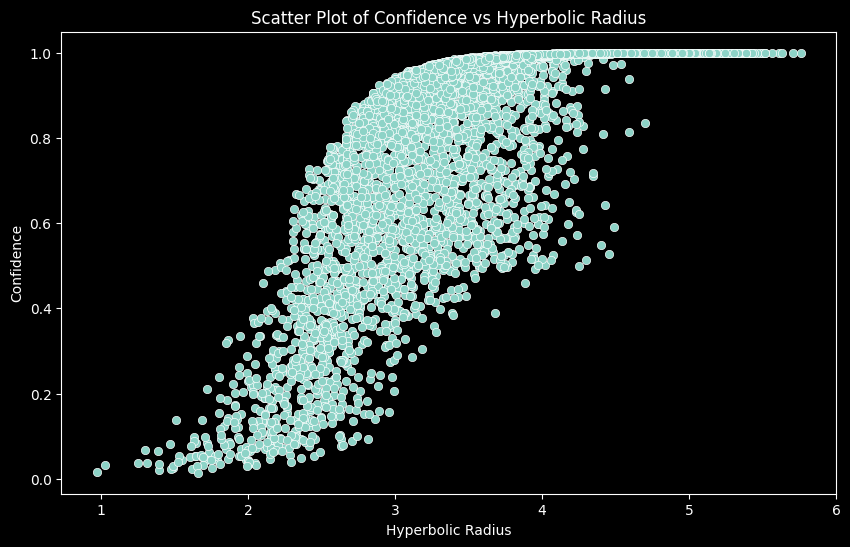

(0.7280309810680777, 0.0, 0.953326072747208, 0.0)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Scatter plot of confidence vs hyperbolic radius
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['hyper_radius'], y=data['confidence'])
plt.title('Scatter Plot of Confidence vs Hyperbolic Radius')
plt.xlabel('Hyperbolic Radius')
plt.ylabel('Confidence')
plt.show()

# Calculate the Pearson correlation coefficient
pearson_corr, pearson_p_value = pearsonr(data['hyper_radius'], data['confidence'])

# Calculate the Spearman rank correlation coefficient
spearman_corr, spearman_p_value = spearmanr(data['hyper_radius'], data['confidence'])

pearson_corr, pearson_p_value, spearman_corr, spearman_p_value
